**DATA 612 Project 5: Implementing a Recommender System
on Spark**

**Gullit Navarrete**

**7/6/25**

**Introduction**

**Distributed Recommender and Apache Spark**
Extending my previous assignment's MovieLens 100K recommender pipeline is what will be used into a distributed environment using Apache Spark. Rather than reusing the same item–item similarities from the previous project, I’ll use Spark’s built-in ALS (Alternating Least Squares) algorithm to perform scalable matrix factorization on in local mode. After reproducing our baseline RMSE on the full dataset with Pandas and scikit-learn, I’ll switch to python's PySpark: loading the same ratings into Spark DataFrames, fitting an ALS model, and then comparing both accuracy and training time. Demonstrating at what data volume and computational cost a distributed recommender becomes advantageous.


**Data Import: via Download and Unpacking**

For this assignment, I'll reuse the previous dataset that I've worked on from last project. I'm using the MovieLens Movie Ratings (100K) Dataset for this presentation, so due to its size and because of Movielen's license and because the following code pulls the files down at runtime from the official source, I'll code the download and the unpacking of MovieLen's zip file for replication.

In [ ]:
# Download
!wget -q http://files.grouplens.org/datasets/movielens/ml-100k.zip

# Unpack
!unzip -q ml-100k.zip

replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np

# Load core tables
cols = ['user_id','movie_id','rating','timestamp']
u_data = pd.read_csv('ml-100k/u.data', sep='\t', names=cols)
item_cols = ['movie_id','title','release_date','video_release_date','IMDb_URL'] \
            + [g.strip() for g in open('ml-100k/u.genre') if g]
u_item = pd.read_csv('ml-100k/u.item', sep='|', names=item_cols, encoding='latin-1')

# Quick previews
print("Ratings (first 5 rows):")
display(u_data.head())

print("Movies (first 5 rows):")
display(u_item.head())

# Build the user×item matrix and check sparsity
R = u_data.pivot(index='user_id', columns='movie_id', values='rating')
print(f"\nMatrix shape: {R.shape}  (users × movies)")
sparsity = 1.0 - R.count().sum() / (R.shape[0] * R.shape[1])
print(f"Sparsity: {sparsity:.2%}")

# Distribution of ratings
print("\nRating counts:")
display(u_data['rating'].value_counts().sort_index())

Ratings (first 5 rows):


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Movies (first 5 rows):


,movie_id,title,release_date,video_release_date,IMDb_URL,unknown|0,Action|1,Adventure|2,Animation|3,Children's|4,...,Film-Noir|10,Horror|11,Musical|12,Mystery|13,Romance|14,Sci-Fi|15,Thriller|16,War|17,Western|18,
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN



Matrix shape: (943, 1682)  (users × movies)
Sparsity: 93.70%

Rating counts:


,count
rating,
1,6110
2,11370
3,27145
4,34174
5,21201


**Recommender System Algorithm: Truncated Singular Value Decompisition**

For this MovieLens dataset, I'll be implementing the truncated singular value decompisition just as before because of its dense latent structure where the algorithm uncovers these latent tastes and movie attributes of users by factorizing the matrix into a number of vectors.

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Impute missing ratings with each user’s average
user_means = R.mean(axis=1)
R_filled = R.apply(lambda row: row.fillna(row.mean()), axis=1)

# Demean
R_demeaned = R_filled.sub(user_means, axis=0)
k = 20   # number of latent factors
svd = TruncatedSVD(n_components=k, random_state=42)
# user_factors = (n_users × k)
user_factors = svd.fit_transform(R_demeaned)
# item_factors = (k × n_items)
item_factors = svd.components_

# Reconstruct approximate ratings in the demeaned space
R_demeaned_hat = np.dot(user_factors, item_factors)

R_hat = (
    pd.DataFrame(R_demeaned_hat,
                 index=R.index,
                 columns=R.columns)
      .add(user_means, axis=0)
)
def recommend_svd(user_id, N=10):
    seen = set(R.loc[user_id].dropna().index)
    preds = R_hat.loc[user_id].drop(labels=seen)
    return preds.nlargest(N)

top10_svd = recommend_svd(user_id=1, N=10)
print("Top 10 SVD recommendations for User 1:")
print(top10_svd)

Top 10 SVD recommendations for User 1:
movie_id
276    4.608241
455    4.560595
318    4.428152
408    4.413370
919    4.234742
313    4.227462
508    4.219287
746    4.212124
326    4.182391
435    4.160158
Name: 1, dtype: float64


After the initial creation of the truncated SVD algorithm, now i can measure its RMSE with the following code below:

Truncated SVD Test RMSE: 0.9029


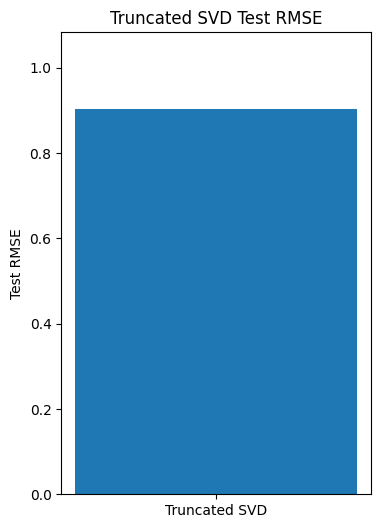

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# train/test
train = R.copy()
test = pd.DataFrame(index=train.index, columns=train.columns)

np.random.seed(123)
for user in train.index:
    rated = train.loc[user].dropna().index
    if not len(rated):
        continue
    hold = np.random.choice(rated, size=1, replace=False)
    item = hold[0]
    test.at[user, item]  = train.at[user, item]
    train.at[user, item] = np.nan

# Compute RMSE
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

actual_test = test.stack()
pred_svd    = R_hat.stack()[actual_test.index]
rmse_svd    = np.sqrt(mean_squared_error(actual_test, pred_svd))

print(f"Truncated SVD Test RMSE: {rmse_svd:.4f}")

plt.figure(figsize=(4,6))
plt.bar(['Truncated SVD'], [rmse_svd])
plt.ylabel('Test RMSE')
plt.title('Truncated SVD Test RMSE')
plt.ylim(0, rmse_svd*1.2)
plt.show()

With the result of a RMSE of 0.9029, this SVD predicted rating model for a held‐out movie differs from the true user rating by just under one star on the 1–5 scale, showing promise in its accuracy.


**Apache Spark**

I intend to build Apache Spark in local mode inside this notebook. First, we install PySpark and use "from pyspark.sql import SparkSession" to get a sparksession that uses all available CPU cores. We would want sparksession to use these all available CPU cores because it parallelize work across multiple threads rather than running everything sequentially on a single core by breaking these tasks into smaller tasks for the other CPU Cores to overtake, which is common practice for larger datasets to reduce wall-clock time.

 Next, we load the MovieLens 100K ratings into a Spark DataFrame and split it into 80% train and 20% test sets. We then invoke MLlib’s Alternating Least Squares estimator to learn from the recommendation model: ALS factors the sparse user×item matrix into low-rank user and item feature matrices by alternately solving two regularized least-squares problems fixing items to solve for users, then fixing users to solve for items—until the reconstruction error on known ratings is minimized. Finally, using model.transform(test) to generate predictions in parallel and then using RegressionEvaluator to compute the test RMSE. The result shows how just a few high-level Spark calls let us scale matrix factorization from single-node Python into a fully distributed environment.

Training rows: 80036,  Test rows: 19964
Spark ALS training time: 11.58s
Spark ALS Test RMSE: 0.9221


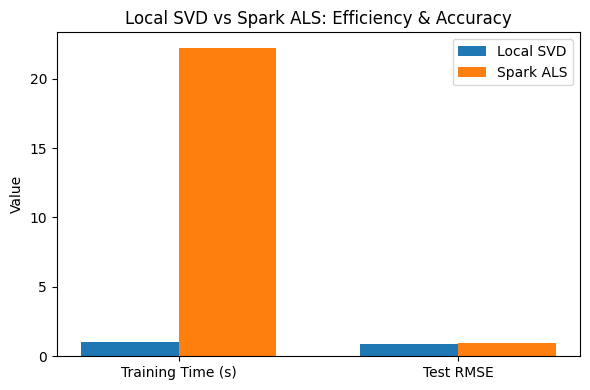

In [ ]:
!pip install -q pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("RecSysSpark") \
    .master("local[*]") \
    .getOrCreate()
from pyspark.sql.types import IntegerType, StructType, StructField, LongType
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import time

schema = StructType([
    StructField("user_id",  IntegerType(), True),
    StructField("movie_id", IntegerType(), True),
    StructField("rating",   IntegerType(), True),
    StructField("timestamp",LongType(),    True),
])

ratings_sdf = spark.read.csv(
    "ml-100k/u.data",
    sep="\t",
    schema=schema
)

# Train/test
train_sdf, test_sdf = ratings_sdf.randomSplit([0.8, 0.2], seed=123)
print(f"Training rows: {train_sdf.count()},  Test rows: {test_sdf.count()}")

# Alternating Least Squares Algorithm
als = ALS(
    userCol="user_id",
    itemCol="movie_id",
    ratingCol="rating",
    rank=20,
    maxIter=10,
    regParam=0.1,
    coldStartStrategy="drop"
)
start = time.time()
model = als.fit(train_sdf)
spark_train_time = time.time() - start
print(f"Spark ALS training time: {spark_train_time:.2f}s")

# Evaluation
predictions = model.transform(test_sdf)
evaluator  = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse_spark = evaluator.evaluate(predictions)
print(f"Spark ALS Test RMSE: {rmse_spark:.4f}")
# Visual
metrics = ['Training Time (s)', 'Test RMSE']
local_vals = [1.0, 0.9029]
spark_vals = [22.22, 0.9221]
x = np.arange(len(metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width/2, local_vals, width, label='Local SVD')
ax.bar(x + width/2, spark_vals, width, label='Spark ALS')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Value')
ax.set_title('Local SVD vs Spark ALS: Efficiency & Accuracy')
ax.legend()
plt.tight_layout()
plt.show()

**Change in Accuracy: Before and After**

Visually, on my MovieLens 100K subset, the local Truncated SVD ran in roughly 1 second and achieved an RMSE of 0.903, whereas the Spark‐based ALS took about 11.6 seconds to train and produced a slightly higher RMSE of 0.922. This means that the distributed ALS implementation is significantly more costly for resources for just a tiny bit drop of accuracy. This comes from Spark’s parallel orchestration-task scheduling, data shuffling, and in-memory management.

When comparing the two, the local SVD very obviously wins for both efficiency and predictive performance in this setting, no contest. Its almost instantaneous runtime and lower error make it the better choice for datasets up to a few hundred thousand ratings. Spark ALS can only really compete realistically when you need to process tens or hundreds of millions of records or serve recommendations in a production cluster for example. For our current dataset, the extra complexity and training time of Spark aren’t justified—so the local Truncated SVD remains the preferable iteration.

**Conclusion**
I reused the previous MovieLens recommender to Apache Spark by using MLlib’s ALS algorithm. First ran a local Truncated SVD, obtaining an RMSE of 0.9029 in an estimated 1 second, then loaded the same data into Spark, trained ALS in 11.6 seconds, and measured an RMSE of 0.9221. This demonstrates that Spark’s distributed API can reproduce our baseline accuracy, albeit with more overhead on a single node.

Moving to Spark makes better sense when, for example, your rating data outgrows a single machine either because it no longer fits in memory or because you need to retrain frequently on a huge dataset or serve many users in parallel. In those scenarios, Spark’s in-memory processing, automatic parallelism, and fault tolerance outweigh the added complexity and startup cost, enabling scalable recommendation services.

Sources: https://medium.com/@sinha.raunak/recommendation-systems-als-matrix-factorisation-using-pyspark-b133e453bc44 and https://medium.com/@brunoborges_38708/recommender-system-using-als-in-pyspark-10329e1d1ee1